# MODFLOW verification

The current notebook describes the procedures and results for the verification of the RBF-AEM model with MODFLOW (Langevin et al. 2021), which is an international standard groundwater simulation model, and MODPATH (. 2017), which is a particle tracking program created for MODFLOW.

## Part 1. MODFLOW model creation

We will begin with the model creation under steady-state conditions. We will use Flopy (Bakker et al. 2016), a python interface for the MODFLOW model and the MODFLOW 6 (Langevin et al. 2021), the last version of the MODFLOW model. 

### Step 1. Importing required libraries

In [1]:
import flopy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Step 2. Creating Model Structure and Properties

### Flopy Simulation Object

In [2]:
name = 'mf6_verif'
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="mf6", version="mf6", sim_ws="."
)

### Flopy time (```TDIS```) Object

In [3]:
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)]
)

### Flopy Groundwater Flow Object (```GWF```)

In [4]:
model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=name,
    model_nam_file=model_nam_file,
    save_flows=True,
)

### Grid Properties

In [5]:
Lx = 1000 #problem lenght [m]
Ly = 1000 #problem width [m]
H = 20  #aquifer height [m]
delx = 1 #block size x direction
dely = 1 #block size y direction
delz = 20 #block size z direction

nlay = 1

ncol = int(Lx/delx) # number of columns

nrow = int(Ly/dely) # number of layers

### Flopy Discretization Object (DIS)

In [6]:
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    xorigin = -1.,
    yorigin = -500.5,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=dely,
    delc=delx,
    top=20.,
    botm=0.,
)

### Flopy Initial Condition Package (```IC```)

In [7]:
h0 = 18
start = h0 * np.ones((nlay, nrow, ncol))
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

### Flopy Node Property Flow Package (```NPF```)

In [8]:
k = 3 # Model conductivity in m/d
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=1, #This we define the model as convertible (water table aquifer)
    k=k,
)

## Step 3. Creating the Model Boundary Conditions

### Constant Head Boundary Package (```CHD```)

To simulate our AEM river in the model, we will use the constant head boundary package. It is the same representation as the one in our model (fixed head in the river location) 

In [9]:
chd_rec = []

for row in range(0, nrow):
    chd_rec.append(((0, row, 0), h0))

chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=chd_rec,
    print_input=True,
    print_flows=True,
    save_flows=True,
)

### WEL Package

We need to simulate fixed inflow condition, which is the base-flow and a fixed outflow condition, which is the pumping well.
To accomplish this, we will use the WEL package, which is a package that defines a fixed inflow-outflow boundary condition, to or from the model.

In [10]:
wel_rec = []
base_flow = 1
for row in range(0, nrow):
    wel_rec.append(((0, row, ncol-1),base_flow , "base_flow"))

x_well = 30.5
y_well = 50
pump_rate = -250
grid = gwf.modelgrid

well_cell = grid.intersect(x_well,y_well)

print(well_cell)

wel_rec.append(((0,well_cell[0],well_cell[1]), pump_rate, "pump_wel"))

wel_obs = {
    "wel_flows.csv": [
        ("base_flow","WEL", "base_flow"),
        ("pump_wel", "WEL", "pump_wel"),
    ],
}

wel = flopy.mf6.ModflowGwfwel(
    gwf,
    boundnames = True,
    save_flows = True,
    stress_period_data=wel_rec,
    observations = wel_obs,
)

(449, 31)


In [11]:
wel.obs.print_input = True

## Step 4. Define Output Control and Solver

### Create Output Control Package: ```OC```

In [12]:
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

### Create Solution Package: ```IMS``` (Solver)

In [13]:
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    complexity="SIMPLE",
    linear_acceleration="BICGSTAB",
    outer_maximum = 300,
    inner_maximum = 500,    
)

## Step 5. Write Simulation and Run Model

In [14]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mf6_verif...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1000 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1001 based on size of stress_period_data
    writing package obs_0...
    writing package oc...


In [15]:
sim.check()

Checking model "mf6_verif"...

mf6_verif MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    npf package: zero or negative horizontal hydraulic conductivity values
    npf package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    npf package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    chd_0 package: BC indices valid
    chd_0 package: not a number (Nan) entries
    wel_0 package: BC indices valid
    wel_0 package: not a number (Nan) entries

Checking for missing simulation packages...


In [16]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: C:\modflowapps\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 22 2020 09:26:42 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources

## Part 2. MODFLOW model postprocessing

### Step 1. Reading the output heads from the MODFLOW model

In [17]:
head = gwf.output.head()

In [18]:
head_array = head.get_data()

#### Plotting the results

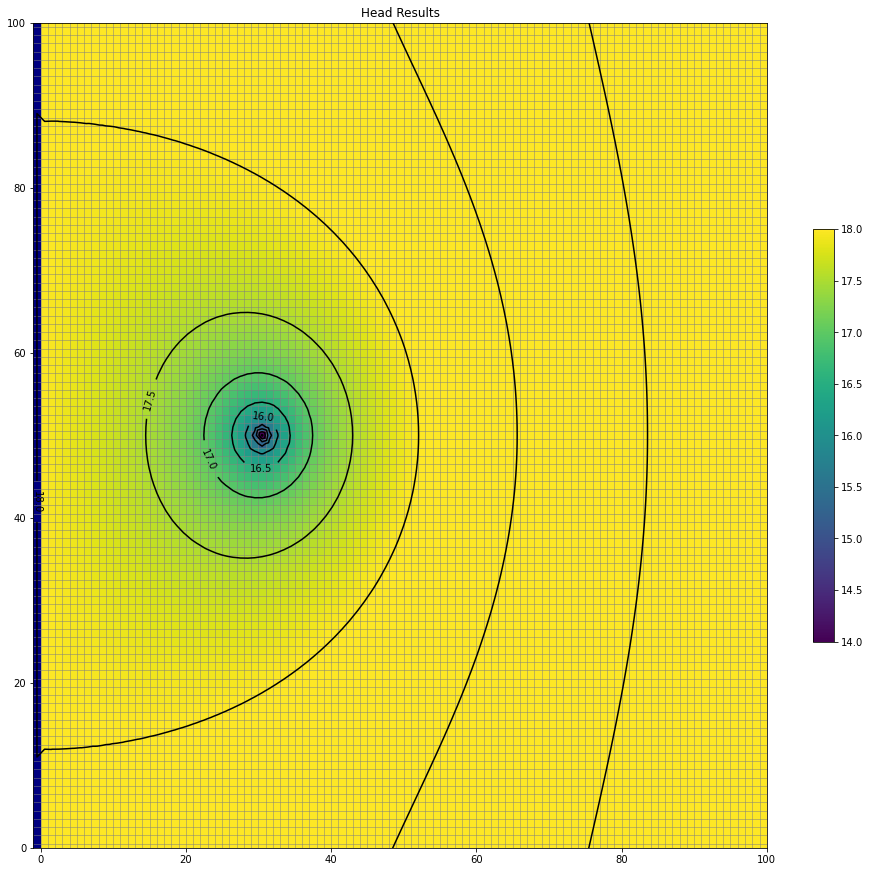

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=True)
# first subplot
contour_intervals = np.arange(10, 20, 0.5)

ax.set_title("Head Results")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax, extent = (-1,100,0,100))
pa = modelmap.plot_array(head_array, vmin = 14, vmax = 18)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    head_array,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)

### Get cross-section arrays for comparison

In [20]:
print(grid.intersect(x_well,0.1))
print(grid.intersect(x_well,100))
print(grid.intersect(0.1,y_well))
print(grid.intersect(100,y_well))

(499, 31)
(399, 31)
(449, 1)
(449, 100)


In [21]:
x_section = head_array[0,well_cell[0],0:100]
y_section = head_array[0,399:499,well_cell[1]]

## Part 3. AEM model calculation

### Step 1. Import libraries

In [22]:
import model_proposal
import solvers

### Step 2. Model Creation and solving results

River Capture Length, Capture position and contribution to discharge is:
(77.3786244941432, [11.310687752928409, 88.6893122470716], 0.2654874755379013)


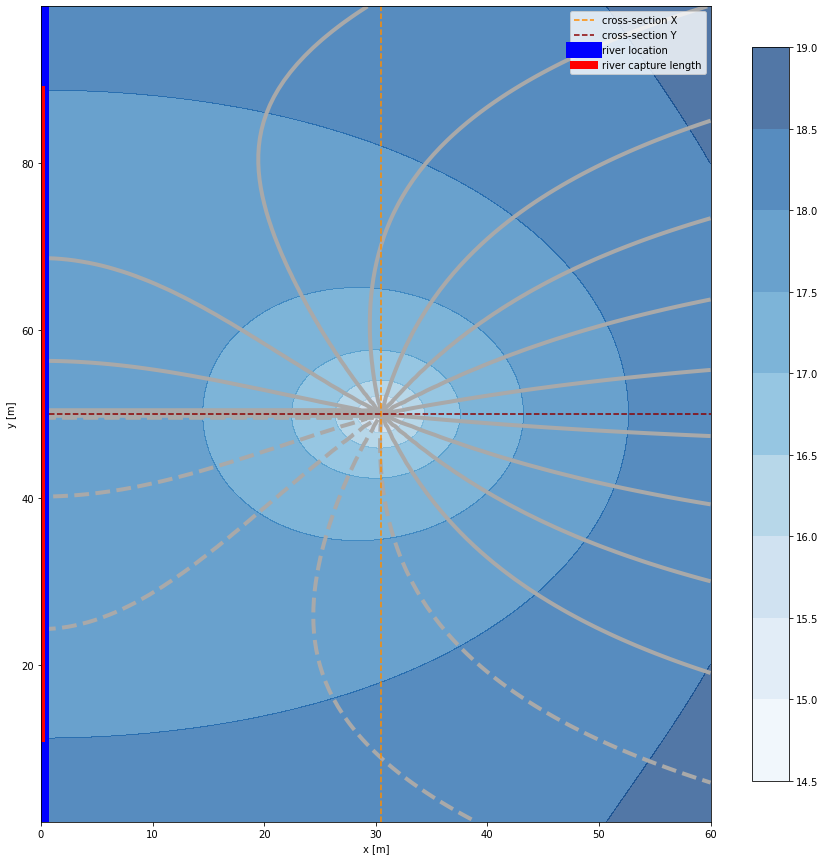

In [23]:
aem_model = model_proposal.Model(k = k, H = 20, h0 = h0)


well = model_proposal.Well(aem_model, Q = 250, rw = 0.1, x = x_well, y = y_well)

solv = solvers.river_length(aem_model)

print("River Capture Length, Capture position and contribution to discharge is:")
print(solv.solve_river_length())

length, riv_coords, capture_fraction = solv.solve_river_length()


### Step 3. Plotting the results

In [ ]:

xvec = np.linspace(0, 60, 100)
yvec = np.linspace(riv_coords[0]-10, riv_coords[1]+10, 100)

xvec, yvec = np.meshgrid(xvec,yvec)

h = []
psi = []
for x,y in zip(xvec.flatten(),yvec.flatten()):
    
    head = aem_model.calc_head(x, y)
    psi_0 = aem_model.calc_psi(x, y)
    
    h.append(head)
    psi.append(psi_0)

h = np.array(h).reshape((100,100))
psi = np.array(psi).reshape((100,100))
from matplotlib import cm
fig2, ax = plt.subplots(figsize = (15,15))
contour = plt.contourf(xvec, yvec, h,
    8,
    cmap = cm.Blues, alpha = 0.7)
    #colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
fig2.colorbar(contour, ax=ax, shrink=0.9)
contour_psi = plt.contour(xvec,yvec,psi,
                          20,
                          colors=('darkgrey',),
                          linewidths=(4,))

ax.vlines(x_well, ymin = np.min(yvec), ymax = np.max(yvec), color = 'darkorange', linestyle = "--", label = 'cross-section X') 
ax.hlines(y_well, xmin = np.min(xvec), xmax = np.max(xvec), color = 'darkred', linestyle = "--", label = 'cross-section Y')

river_line = plt.plot([0,0],[np.min(yvec),np.max(yvec)], color = 'blue', linestyle = '-', linewidth = 16, label = "river location")
river_capture = plt.plot([0, 0], [riv_coords[0], riv_coords[1]], color='r', linestyle='-', linewidth=8, label = "river capture length")
ax.legend()

## Part 4. Model Comparison

### 4.1. Head Comparison

In [24]:
x_section_aem  = []
for x in np.arange(0,100, 0.5):
    x_section_aem.append(aem_model.calc_head(x,y_well))
y_section_aem = []
for y in range(0,101):
    y_section_aem.append(aem_model.calc_head(x_well,y))
x_section_aem = np.array(x_section_aem)
y_section_aem = np.array(y_section_aem)
x_section_aem.shape

(200,)

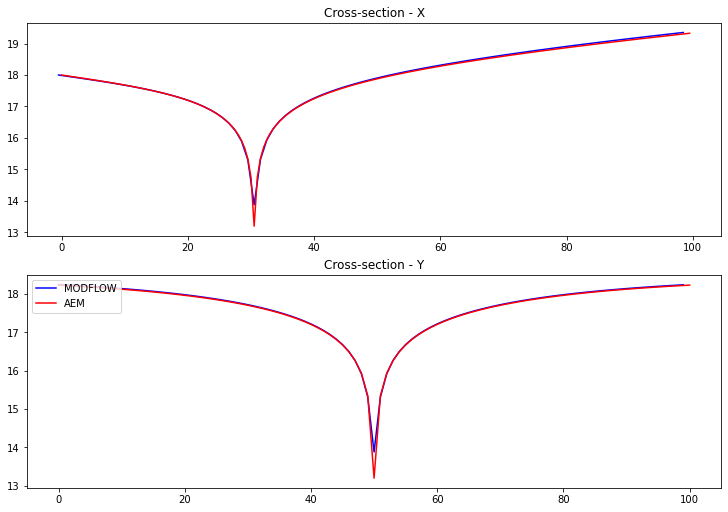

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7), constrained_layout=True)

axs[0].set_title("Cross-section - X")
axs[0].plot(np.arange(-0.5,99.5), x_section, color = "b", label = "MODFLOW")
axs[0].plot(np.arange(0,100,0.5),x_section_aem, color = "r", label = "AEM")


axs[1].set_title("Cross-section - Y")
axs[1].plot(y_section, color = "b", label = "MODFLOW")
axs[1].plot(y_section_aem, color = "r", label = "AEM")
plt.legend(loc = "upper left")

fig.savefig("cross_sec.png")

### 4.2. River Intersection Comparison

In [26]:
# Get the flow budget from the CHD object:
chd_bud = gwf.output.budget().get_data(text="CHD")[0]
index = chd_bud['node2'][chd_bud['q']>0]-1
#Extract the coordinates where there is river bank infiltration:
riv_array = grid.xyzcellcenters[1][index]

#### Output from AEM model:

In [27]:
solv = solvers.river_length(aem_model)

print("River Capture Length, Capture position and contribution to discharge is:")
print(solv.solve_river_length())

River Capture Length, Capture position and contribution to discharge is:
(77.3786244941432, [11.310687752928409, 88.6893122470716], 0.2654874755379013)


#### Output from MODFLOW model:

In [28]:
river_length = riv_array.max()-riv_array.min()
contrib_discharge = chd_bud['q'][chd_bud['q']>0].sum()/-pump_rate
print("River Capture Length, Capture position and contribution to discharge is:")

print((river_length, [riv_array.min(),riv_array.max()], contrib_discharge))

River Capture Length, Capture position and contribution to discharge is:
(76.0, [12.0, 88.0], 0.2519537907922492)


### 4.3. Traveltime Comparison

#### Step 1. Create and Run MODPATH

In [29]:
# create modpath files
mpnamf = name + "_mp_forward"





# create basic forward tracking modpath simulation
mp = flopy.modpath.Modpath7.create_mp7(
    modelname=mpnamf,
    trackdir="forward",
    flowmodel=gwf,
    model_ws='.',
    rowcelldivisions=1,
    columncelldivisions=1,
    layercelldivisions=1,
    exe_name='mp7',
    nodes = chd_bud['node'][chd_bud['q']>0.001]-1
)

#Create MPBAS package file:
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.3)

# write modpath datasets
mp.write_input()


In [30]:

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: C:\modflowapps\mp7.EXE

MODPATH Version 7.2.001   
Program compiled Jul 31 2021 15:01:06 with IFORT compiler (ver. 20.21.2)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        77 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Reading the output: (path + endpoints)

In [31]:
#Get pathline:
p = flopy.utils.PathlineFile(mpnamf + ".mppth")
e = flopy.utils.EndpointFile(mpnamf + ".mpend")
pw = p.get_destination_pathline_data(dest_cells = grid.get_node((0,well_cell[0],well_cell[1])))
ew = e.get_destination_endpoint_data(dest_cells=grid.get_node((0,well_cell[0],well_cell[1])))

### Plotting MODPATH results

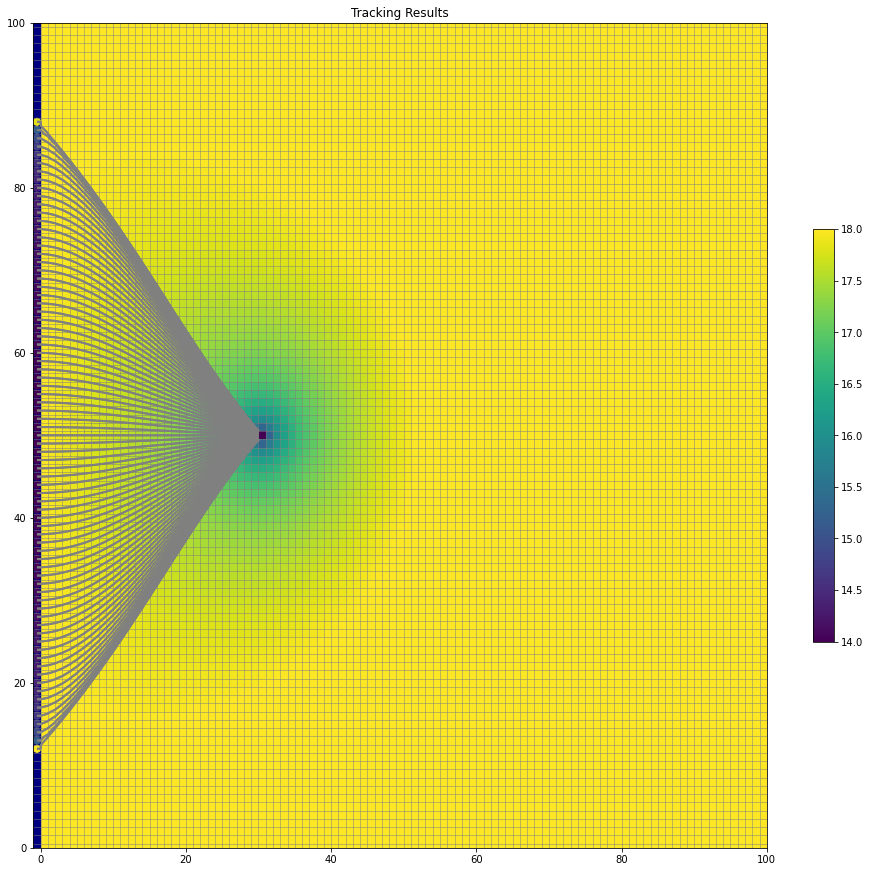

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=True)

ax.set_title("Tracking Results")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax, extent = (-1,100,0,100))
pa = modelmap.plot_array(head_array, vmin = 14, vmax = 18)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
modelmap.plot_pathline(pw, layer=0, lw=2)
modelmap.plot_endpoint(ew, direction="starting", colorbar=False)
cb = plt.colorbar(pa, shrink=0.5, ax=ax)
plt.savefig("pathline_fig.png")

#### Getting MODPATH travel time results

In [33]:
ttmodpath = e.get_destination_endpoint_data(dest_cells=grid.get_node((0,well_cell[0],well_cell[1])))['time']

#### Calculating Travel Times with AEM model

In [34]:
import warnings
warnings.filterwarnings('ignore')
tt, ys, avgtt, mintt, traj_array = solv.time_travel(0.3, delta_s = 0.1, calculate_trajectory = True)

Time of Travel: 
[861.09871362 344.87001371 234.02833335 172.06743727 131.70806488
 104.00611358  84.83527732  71.93811126  63.97866864  60.18039683
  60.18039683  63.97866864  71.93811126  84.83527732 104.00611358
 131.70806488 172.06743747 234.02832613 344.87001283 861.09541386]


#### getting the y location of the starting points from the modflow model for comparison

In [35]:
ys_modpath = grid.xyzcellcenters[1].flatten()[chd_bud['node'][chd_bud['q']>0.001]-1]

### Plotting the travel time of particles located in the y-coordinate of the river

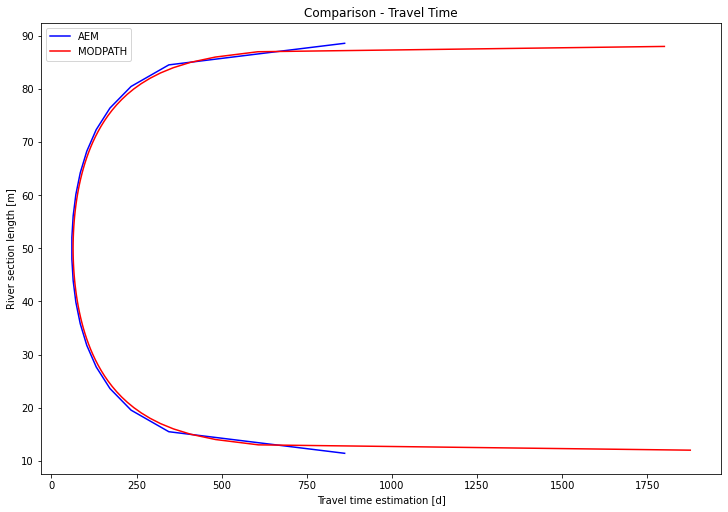

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7), constrained_layout=True)

axs.set_title("Comparison - Travel Time")
axs.plot(tt, ys, color = "b", label = "AEM")
axs.plot(ttmodpath, ys_modpath, color = "r", label = "MODPATH")
axs.legend()
axs.set_ylabel("River section length [m]")
axs.set_xlabel("Travel time estimation [d]")
plt.savefig("traveltime_comp.png")

#### Average Travel Time [d]:

In [37]:
avgtt

96.0408234054722

#### Minimum Travel Time [d]:

In [38]:
mintt

60.18039682512807

### Plotting in the same style for comparison:

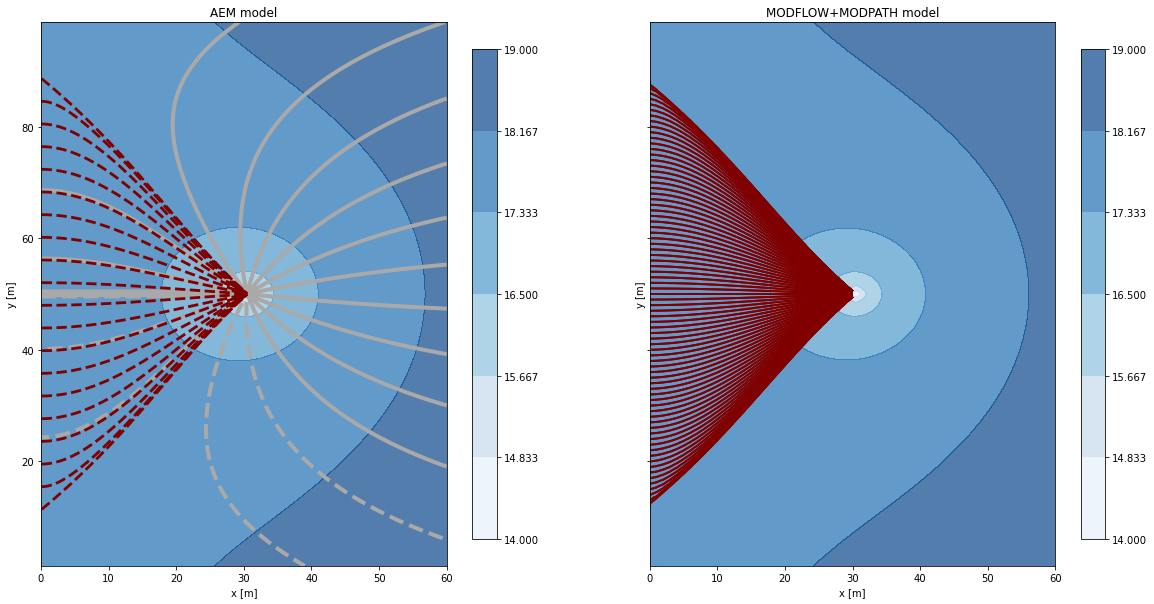

In [39]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize = (20,10))

contour = ax[0].contourf(xvec, yvec, h,
    levels = np.linspace(14,19,7),
    cmap = cm.Blues, alpha = 0.7)
    #colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')

ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('y [m]')
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('y [m]')
ax[0].set_title("AEM model")
ax[1].set_title("MODFLOW+MODPATH model")


contour_psi = ax[0].contour(xvec,yvec,psi,
                          20,
                          colors=('darkgrey',),
                          linewidths=(4,),
                          linestyle = ('-',))

for trajectory in traj_array:
                ax[0].plot(trajectory[0,:],trajectory[1,:],linestyle = '--', 
                           linewidth=2.8, color = "maroon", label = "particle trajectory")

contour_modflow = ax[1].contourf(grid.xyzcellcenters[0], grid.xyzcellcenters[1], head_array[0,:,:],
                               levels = np.linspace(14,19,7),
                               cmap = cm.Blues, alpha = 0.7)
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax[1], extent = (np.min(xvec), np.max(xvec),np.min(yvec), np.max(yvec)))
ax[1].set_xlim(np.min(xvec), np.max(xvec))
ax[1].set_ylim(np.min(yvec), np.max(yvec))
modelmap.plot_pathline(pw, layer=0, lw=2, colors = 'maroon')
fig.colorbar(contour, ax=ax[0], shrink=0.9)
fig.colorbar(contour_modflow, ax=ax[1], shrink=0.9)

plt.savefig('model_comparison.png')
#ax[0].legend()

## Part 5. Adding more wells and comparing multi-well solution:

### 5.1. Adding new wells to MODFLOW model

In [40]:
# clean up for next example
gwf.remove_package("wel_0")
# Rewritting the well file:
wel_rec = []
base_flow = 1
for row in range(0, nrow):
    wel_rec.append(((0, row, ncol-1),base_flow , "base_flow"))

x_well = 30.5
y_well = 50
pump_rate = -250
grid = gwf.modelgrid

well_cell = grid.intersect(x_well,y_well)

print(well_cell)

wel_rec = wel_rec + [((0,well_cell[0],well_cell[1]), pump_rate, "pump_wel"),
               ((0,grid.intersect(10.5,30)[0],grid.intersect(10.5,30)[1]), -100, "pump_wel"),
               ((0,grid.intersect(50.5,10)[0],grid.intersect(50.5,10)[1]),-50, "pump_wel"),
               ]

wel_obs = {
    "wel_flows.csv": [
        ("base_flow","WEL", "base_flow"),
        ("pump_wel", "WEL", "pump_wel"),
    ],
}

wel = flopy.mf6.ModflowGwfwel(
    gwf,
    boundnames = True,
    save_flows = True,
    stress_period_data=wel_rec,
    observations = wel_obs,
)

(449, 31)


In [41]:
wel

package_name = wel_0
filename = mf6_verif.wel
package_type = wel
model_or_simulation_package = model
model_name = mf6_verif

Block options
--------------------
boundnames
{internal}
(True)

save_flows
{internal}
(True)

obs_filerecord
{internal}
(rec.array([('mf6_verif.wel.obs',)],
          dtype=[('obs6_filename', 'O')]))


Block period
--------------------
stress_period_data
{internal}
(rec.array([((0, 0, 999),    1., 'base_flow'),
           ((0, 1, 999),    1., 'base_flow'),
           ((0, 2, 999),    1., 'base_flow'), ...,
           ((0, 449, 31), -250., 'pump_wel'),
           ((0, 469, 11), -100., 'pump_wel'),
           ((0, 489, 51),  -50., 'pump_wel')],
          dtype=[('cellid', 'O'), ('q', '<f8'), ('boundname', 'O')]))



In [42]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mf6_verif...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
    writing package oc...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1003 based on size of stress_period_data
    writing package obs_0...


### 5.2. Adding new wells to AEM model:

In [43]:
well2 = model_proposal.Well(aem_model, Q = 100, rw = 0.2, x = 10.5, y = 30)

well3 = model_proposal.Well(aem_model, Q = 50, rw = 0.2, x = 50.5, y = 10)


### 5.3. Running both Models:

In [44]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: C:\modflowapps\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 22 2020 09:26:42 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources

In [45]:
h = []
psi = []
for x,y in zip(xvec.flatten(),yvec.flatten()):
    
    head = aem_model.calc_head(x, y)
    psi_0 = aem_model.calc_psi(x, y)
    
    h.append(head)
    psi.append(psi_0)

h = np.array(h).reshape((100,100))
psi = np.array(psi).reshape((100,100))

In [46]:
head = gwf.output.head()

In [47]:
head_array = head.get_data()

### 5.4. Plotting Results

#### Getting cross-sections

In [48]:
x_section1 = head_array[0,well_cell[0],0:100]
x_section2 = head_array[0,grid.intersect(10.5,30)[0],0:100]
x_section3 = head_array[0,grid.intersect(50.5,10)[0],0:100]
y_section1 = head_array[0,399:500,well_cell[1]]
y_section2 = head_array[0,399:500,grid.intersect(10.5,30)[1]]
y_section3 = head_array[0,399:500,grid.intersect(50.5,10)[1]]
y_section1 = y_section1[::-1]
y_section2= y_section2[::-1]
y_section3 = y_section3[::-1]


In [49]:
x_section_aem1  = []
x_section_aem2 = []
x_section_aem3 = []
for x in np.arange(0,100, 0.5):
    x_section_aem1.append(aem_model.calc_head(x,y_well))
    x_section_aem2.append(aem_model.calc_head(x,30))
    x_section_aem3.append(aem_model.calc_head(x,10))
y_section_aem1 = []
y_section_aem2 = []
y_section_aem3 = []
for y in range(0,101):
    y_section_aem1.append(aem_model.calc_head(x_well,y))
    y_section_aem2.append(aem_model.calc_head(10.5,y))
    y_section_aem3.append(aem_model.calc_head(50.5,y))
x_section_aem1 = np.array(x_section_aem1)
x_section_aem2 = np.array(x_section_aem2)
x_section_aem3 = np.array(x_section_aem3)

y_section_aem1 = np.array(y_section_aem1)
y_section_aem2 = np.array(y_section_aem2)
y_section_aem3 = np.array(y_section_aem3)



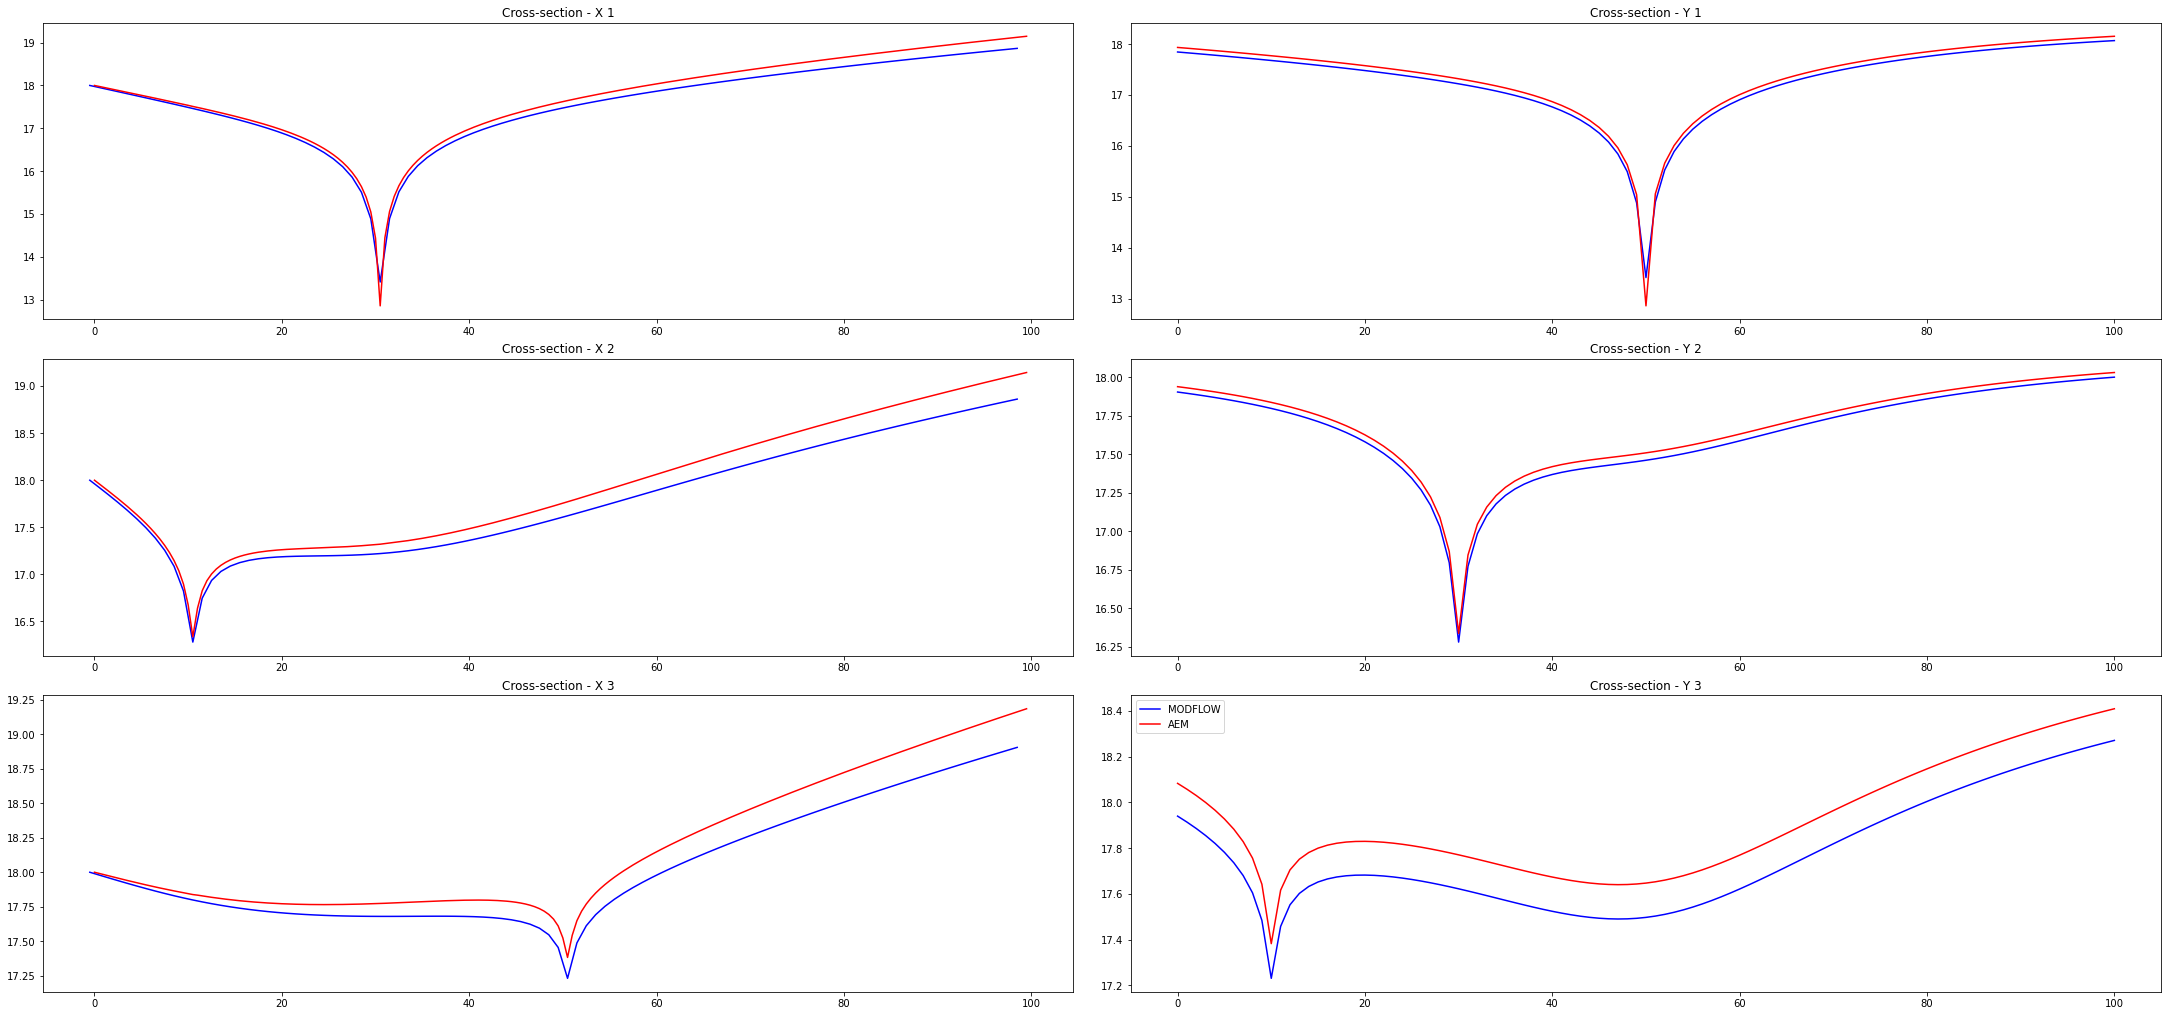

In [50]:
fig, axs = plt.subplots(3, 2, figsize=(30, 14), constrained_layout=True)

axs[0,0].set_title("Cross-section - X 1")
axs[0,0].plot(np.arange(-0.5,99.5),x_section1, color = "b", label = "MODFLOW")
axs[0,0].plot(np.arange(0,100,0.5),x_section_aem1, color = "r", label = "AEM")

axs[1,0].set_title("Cross-section - X 2")
axs[1,0].plot(np.arange(-0.5,99.5),x_section2, color = "b", label = "MODFLOW")
axs[1,0].plot(np.arange(0,100,0.5),x_section_aem2, color = "r", label = "AEM")

axs[2,0].set_title("Cross-section - X 3")
axs[2,0].plot(np.arange(-0.5,99.5),x_section3, color = "b", label = "MODFLOW")
axs[2,0].plot(np.arange(0,100,0.5),x_section_aem3, color = "r", label = "AEM")

axs[0,1].set_title("Cross-section - Y 1")
axs[0,1].plot(y_section1, color = "b", label = "MODFLOW")
axs[0,1].plot(y_section_aem1, color = "r", label = "AEM")

axs[1,1].set_title("Cross-section - Y 2")
axs[1,1].plot(y_section2, color = "b", label = "MODFLOW")
axs[1,1].plot(y_section_aem2, color = "r", label = "AEM")

axs[2,1].set_title("Cross-section - Y 3")
axs[2,1].plot(y_section3, color = "b", label = "MODFLOW")
axs[2,1].plot(y_section_aem3, color = "r", label = "AEM")
plt.legend(loc = "upper left")

fig.savefig("cross_sec_multi.png")

### 2D plotting of results

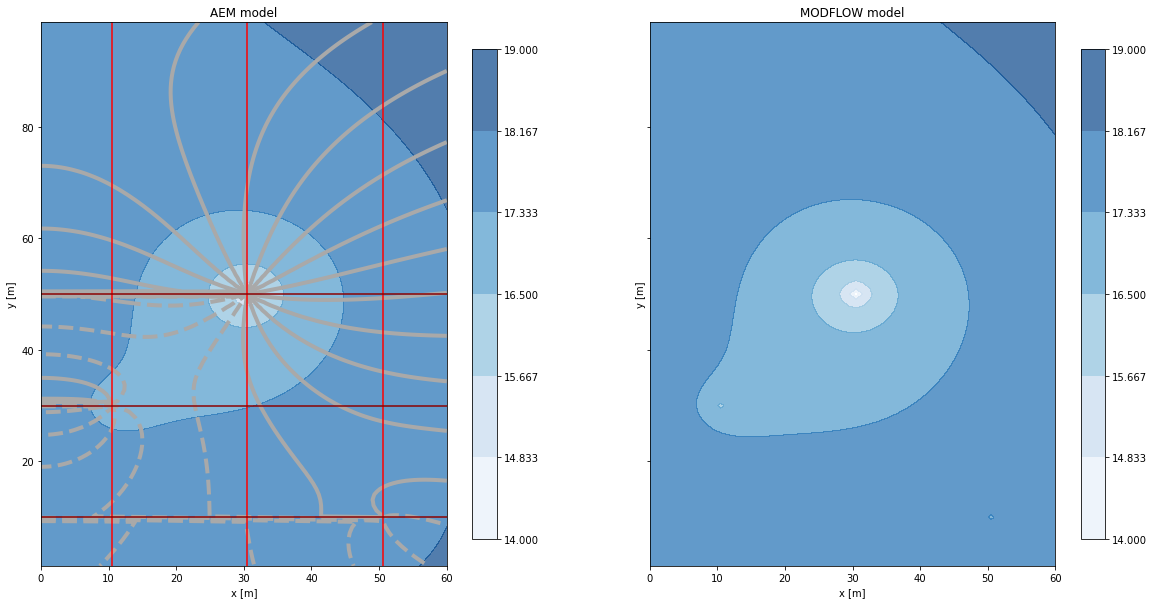

In [51]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize = (20,10))

contour = ax[0].contourf(xvec, yvec, h,
    levels = np.linspace(14,19,7),
    cmap = cm.Blues, alpha = 0.7)
    #colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')

ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('y [m]')
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('y [m]')
ax[0].set_title("AEM model")
ax[1].set_title("MODFLOW model")


contour_psi = ax[0].contour(xvec,yvec,psi,
                          20,
                          colors=('darkgrey',),
                          linewidths=(4,),
                          linestyle = ('-',))

contour_modflow = ax[1].contourf(grid.xyzcellcenters[0], grid.xyzcellcenters[1], head_array[0,:,:],
                               levels = np.linspace(14,19,7),
                               cmap = cm.Blues, alpha = 0.7)

ax[0].vlines([10.5,30.5,50.5], ymin = 0, ymax = 100, color = "red", label = "y-direction")
ax[0].hlines([10, 30, 50], xmin = 0, xmax = 100, color = "darkred", label = "x-direction")

ax[1].set_xlim(np.min(xvec), np.max(xvec))
ax[1].set_ylim(np.min(yvec), np.max(yvec))
fig.colorbar(contour, ax=ax[0], shrink=0.9)
fig.colorbar(contour_modflow, ax=ax[1], shrink=0.9)

#ax[0].legend()
fig.savefig('multiwell_comp.png')